In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [2]:
images = Path('datasets/test_imgs')
outputs = Path('outputs/test_imgs/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

2 mapping images


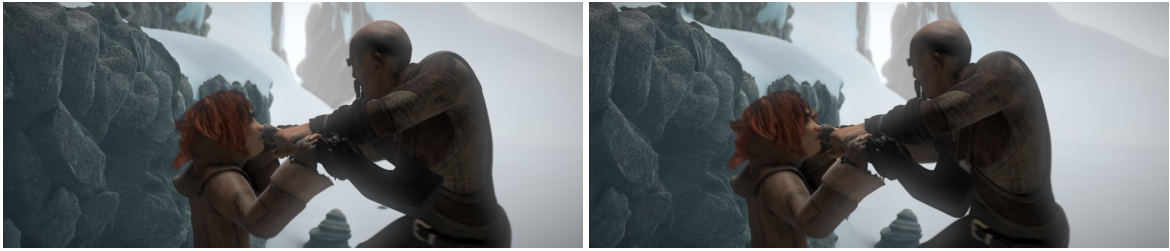

In [3]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25, figsize=10)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [4]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/12/03 00:48:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
/home/tina/anaconda3/envs/dl_dev/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/2 [00:00<?, ?it/s]

[2023/12/03 00:48:19 hloc INFO] Finished exporting features.
[2023/12/03 00:48:19 hloc INFO] Found 1 pairs.
[2023/12/03 00:48:19 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/home/tina/anaconda3/envs/dl_dev/lib/python3.8/site-packages/lightglue/lightglue.py:141: UserWarning: FlashAttention is not available. For optimal speed, consider installing torch >= 2.0 or flash-attn.
  self.inner_attn = Attention(flash)


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/12/03 00:48:22 hloc INFO] Finished exporting matches.


[['mapping/img1.jpg', 'mapping/img2.jpg']]


  0%|          | 0/1 [00:00<?, ?it/s]

[[505. 356.]]


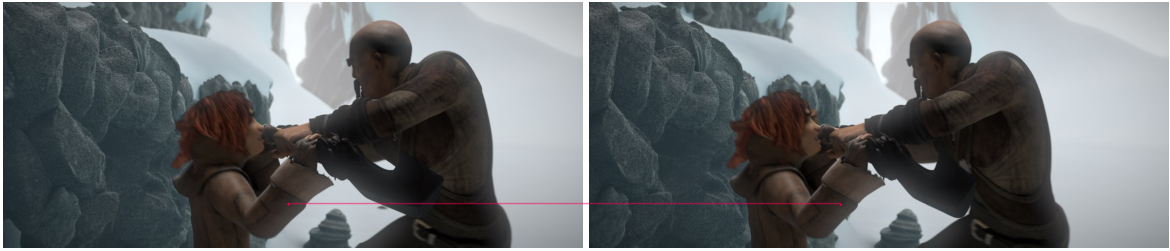

In [5]:
from hloc.utils.viz import plot_images, plot_matches
from hloc.utils.io import get_matches, get_keypoints
img1_name = 'mapping/img1.jpg'
img2_name = 'mapping/img2.jpg'
img1 = read_image(images / img1_name)
img2 = read_image(images / img2_name)
plot_images([img1, img2], dpi=25, figsize=10)
with open(str(sfm_pairs), 'r') as f:
    pairs = [p.split() for p in f.readlines()]
    print(pairs)
for name0, name1 in tqdm.tqdm(pairs):
    matches_info, _ = get_matches(matches, name0, name1)
    kps1 = get_keypoints(features, img1_name, return_uncertainty=False)
    kps2 = get_keypoints(features, img2_name, return_uncertainty=False)
    idxs = np.random.choice(matches_info.shape[0], size=1)
    pts1 = kps1[matches_info[idxs,0]]
    pts2 = kps2[matches_info[idxs,1]]
    print(pts1)
    plot_matches(pts1, pts2, lw=4, ps=20, a=0.5)

Find E matrix using COLMAP

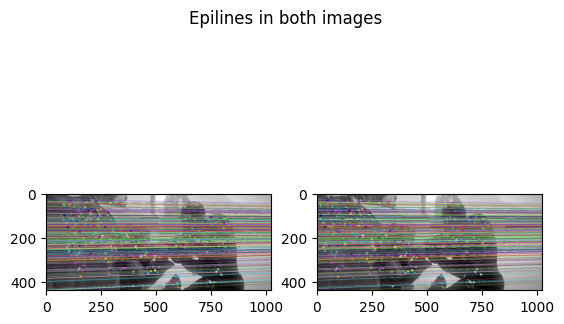

In [7]:
import cv2
from stereo_reconstruct import visualize_epilines, visualize_rectify, rectify_from_correspondences

idxs = np.random.choice(matches_info.shape[0], size=400)
pts1 = kps1[matches_info[idxs,0]]
pts2 = kps2[matches_info[idxs,1]]

img1_g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
F, H1, H2 = rectify_from_correspondences(pts1, pts2, img1_g, img2_g)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
visualize_epilines(F, pts1, pts2, img1_g, img2_g)

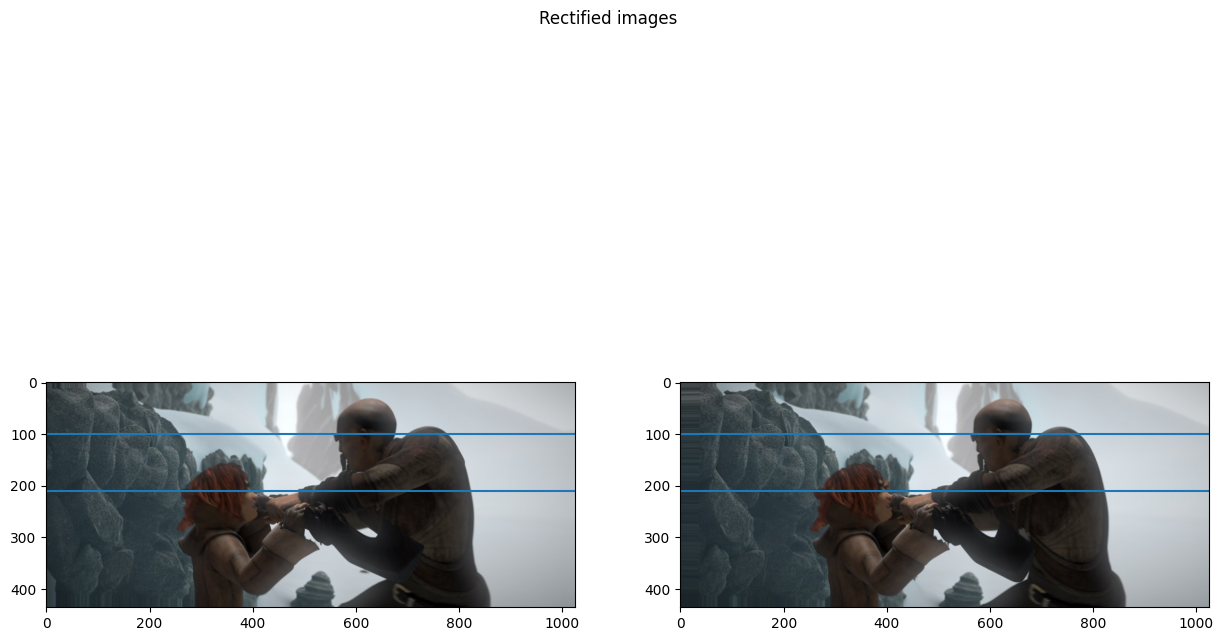

In [10]:
visualize_rectify(H1, H2, img1, img2)